In [126]:
from IPython.core.display import display, HTML
import bisect
from collections import defaultdict
import jieba
import pickle

class MySearchC5V0():
    """
    C3V0: Base class for Search Engine.
    C3V1: Data multiplication added.
    C3V2: Sorting optimization.
    C3V3: Add lowered version of docs.
    C3V4: For long doc.
    C3V5: Caching search results.
    C3V6: Pre-caching all words in docs.
    C3V7: Add Serialize/UnSerialize.
    C4V1: Add basic Bool query support
    C4V2: Add wordseg to get_word_match()
    ----------------C5V0-----------------

    Attributes
    ----------
    filename : str
        file name of doc data
    multi_factor : int
        data multiplication factor(default 1)

    Methods
    -------
    load_data(filename):
        load data from file.
    save_data(filename):
        save data to file
    pre_cache_all():
        Pre-caching all words in docs.
    highlight(text, keyword):
        highlight text with keyword.
    score(text, keyword):
        get score of text for a query.
    get_word_match(self, keyword):
        get doc set containing keyword.
    search(keyword, num=15):
        get top num search results of a query.
    render(result_list, keyword):
        output search results with highlight.
    query_to_set_expression(query):
        convert bool query to set expression(for eval process).
    get_word_match(word):
        get match set of the word.
    """
    
    def __init__(self, filename, multi_factor=1):
        self.docs = []
        self.docs_lower = []
        self.search_cache = defaultdict(set)
        self.multi_factor = multi_factor
        self.load_data(filename)
    
    def highlight(self, text, keyword, ori_text):
        idx = text.find(keyword)
        result = text
        if idx >= 0:
            ori_keyword = ori_text[idx:idx+len(keyword)]
            result = ori_text.replace(ori_keyword, f'<span style="color:red">{ori_keyword}</span>')
        return result
    
    def score(self, text, keyword):
        result = text.count(keyword)
        return result
    
    def query_to_set_expression(self, query):
        query_new_parts = []
        all_parts = list(query.replace('(', ' ( ').replace(')', ' ) ').split())
        idx = 0
        cache = ''
        count_parts = len(all_parts)
        while idx < count_parts:
            if all_parts[idx] == '(' or all_parts[idx] == ')':
                query_new_parts.append(all_parts[idx])
            elif all_parts[idx] == ' ' or all_parts[idx] == '':
                query_new_parts.append(' ')
            elif all_parts[idx] in ('and', 'AND', '+'):
                query_new_parts.append('&')
            elif all_parts[idx] in ('or', 'OR'):
                query_new_parts.append('|')
            elif all_parts[idx] in ('not', 'NOT', '-'):
                query_new_parts.append('-')
            else:
                if cache:
                    cache += ' ' + all_parts[idx]
                else:
                    cache = all_parts[idx]

                if (idx + 1 == count_parts
                  or all_parts[idx + 1] in ('(', ')', 'and', 'AND', '+', 'or', 'OR', 'NOT', 'not', '+', '-', ' ', '')):
                    query_new_parts.append(f"self.get_word_match('{cache}')")
                    cache = ''
            idx += 1
        query_new = ''.join(query_new_parts)
        return query_new
    
    def get_word_match(self, word):
        if_first_subword = True
        result = None
        for term in list(jieba.cut(word)):
            if if_first_subword:
                result = self.search_cache[term]
                if_first_subword = False
            else:
                result = result & self.search_cache[term]
            if not result:
                break
        return result
    
    def search(self, query, num=15):
        query_lower = query.lower()    
        result_list = []
        min_score = 0
        query_new = self.query_to_set_expression(query_lower)
        for tid in eval(query_new):
            doc = self.docs_lower[tid]
            score = 1 #self.score(doc, keyword_lower)
            if len(result_list) == num:
                if score > min_score:
                    insert_idx = bisect.bisect(
                        [doc_score[1] for doc_score in result_list], 
                        score
                    )
                    min_score = result_list[0][1]
                    result_list = result_list[1:insert_idx] + \
                                    [(tid, score)] + \
                                    result_list[insert_idx:]
            elif len(result_list) < num - 1:
                result_list.append((tid, score))
            elif len(result_list) == num - 1:
                result_list.append((tid, score))
                result_list.sort(key = lambda x: x[1])
                min_score = result_list[0][1]
        return [doc_id for doc_id, _ in result_list[::-1]]
    
    def render(self, result_list, keyword):
        count = 1
        for item in result_list:
            result = self.highlight(
                self.docs_lower[item], 
                keyword.lower(), 
                self.docs[item]
            ).replace('$$$', '<br/>') #
            display(HTML(f"{count}、{result[:150]}......")) #
            count += 1
            
    def pre_cache_all(self):
        for tid, doc in enumerate(self.docs_lower):
            for word in jieba.cut_for_search(doc):
                self.search_cache[word].add(tid)
                
    def load_data(self, filename):
        if filename[-3:] == 'txt':
            with open(filename, 'r') as f:
                self.docs = f.read().split('\n')
            self.docs_lower = [doc.lower() for doc in self.docs]
            self.docs = self.docs * self.multi_factor 
            self.docs_lower = self.docs_lower * self.multi_factor
            self.pre_cache_all()
        elif filename[-3:] == 'dat':
            with open(filename, 'rb') as f:
                self.docs, self.docs_lower, self.search_cache = pickle.load(f)
                
    def save_data(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump((self.docs, self.docs_lower, self.search_cache), f)
            

## score()函数的改进 ——> 查询/文档相似度打分(Ranking)

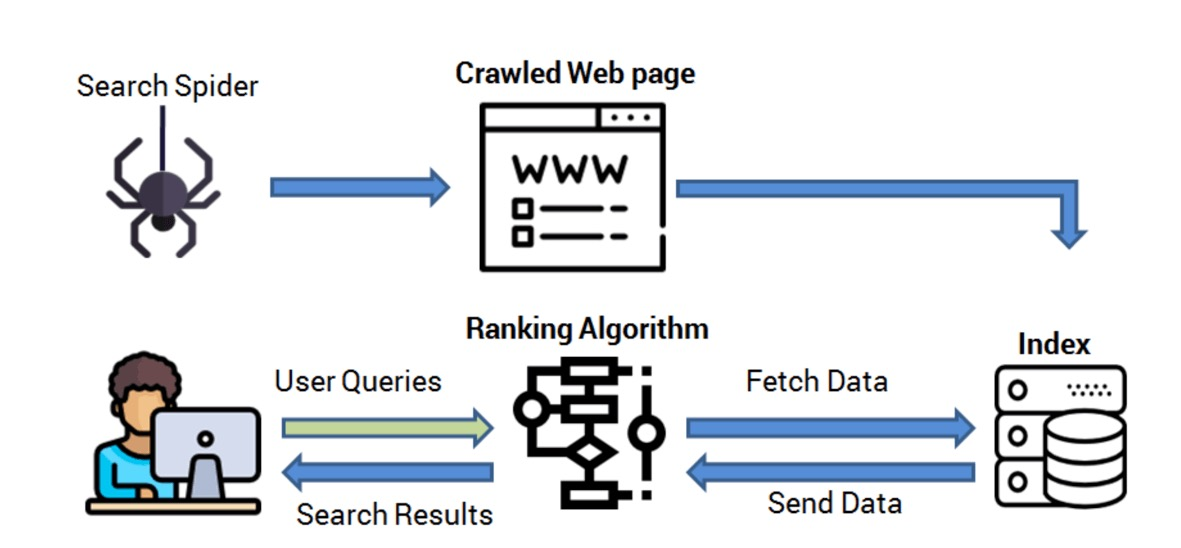

### 如何评价查询和文档之间的相关度？
#### 语义、意图、类型等多种`隐性`维度

#### 最直接的想法：对`查询`和`文档`之间`共同出现词`进行计数
\begin{equation}
\operatorname{score}(Q, D)=|Q \bigcap D|
\end{equation}

### * 词袋模型

In [125]:
import jieba

def score_intersection(doc1, doc2):
    word_set_doc1 = set(jieba.cut(doc1.lower()))
    word_set_doc2 = set(jieba.cut(doc2.lower()))
    return len(word_set_doc1 & word_set_doc2)

In [127]:
q = 'iphone 手机'

doc_1 = 'iPhone 13系列大降价！国产手机难受了$$$华为手机逐渐退出主流市场后，其余国产手机品牌抓住机会努力冲击高端市场。但可惜的是，随着苹果iPhone 13的发布，国产手机品牌高端化进程受到严重冲击。由于全球缺芯和部分原材料涨价，苹果iPhone 13系列在发布之前被认为会略微涨价。但实际情况是，网友们一直调侃的“十三香”确实应验了，iPhone 13系列的国行售价相比前代iPhone便宜了300元-800元，而美版价格则保持不变。对于中国消费者来说，苹果iPhone 13系列加量不加价自然是一件大好事。但是对于国内的智能手机厂商来说，iPhone 13系列的降价可能会破坏国产手机厂商的高端化进程。我们来看看苹果iPhone 13系列的售价：iPhone 13 mini 128G 版价格为5199元，256GB版5999元、512GB版7599元，iPhone 13 128GB版5999元、256GB版6799元、512GB版8399元。iPhone 13 Pro 128GB版7999元、256GB版8799元、512GB版10399元、1T版11999元，iPhone 13 Pro Max 128GB版8999元、256GB版9799元、512GB版11399元、1T版12999元。除了价格下降以外，iPhone 13系列的各项参数也有不小的提升，尤其是在续航方面。根据知名数码评测博主@小白测评的数据，iPhone 13 Pro Max和iPhone 13两款机型重度使用5小时后，仍旧剩余不少电量。尤其是iPhone 13 Pro Max在五小时深度续航测试中表现十分优秀，剩余电量35%，远超其他智能手机，位列排行榜第一。除此之外，iPhone 13系列另一个最明显的升级是支持120Hz高刷，进一步提升了流畅度。而在拍照、摄影方面，此次iPhone 13系列也同样有较大幅度地升级，特别是电影模式的加入，让手机专业摄影成为可能。在加量不加价后，苹果iPhone 13相较国产安卓高端手机的优势就更大了。目前国产高端手机的价位普遍来到5000-8000元，但是在性能、录影、续航、系统生态体验等方面与iPhone 13存在较大差距，这很可能导致国内高端市场被苹果“垄断”。随着苹果iPhone 13系列降价，并且补齐了续航、高刷新率等短板，安卓旗舰手机是否还值得购买？曾几何时，华为凭借在影像方面的创新一步步站稳高端市场，而华为的成功对于其他国产手机厂商冲击高端市场具有极其深远的借鉴意义。因此，影像成为了安卓旗舰手机对比iPhone 13 Pro为数不多的优势之一。今年苹果iPhone 13系列在相机参数方面并没有大幅升级，主摄依然是1200万像素，但是升级了CMOS图像传感器和光圈，提升了进光量，整体硬件差距仍然和安卓阵营有较大的差距。虽然目前手机影像已经进入计算摄影时代，算法可能比硬件更加重要，但是华为、三星等一众顶级厂商的算法也并不差。因此，凭借更强的硬件素质，安卓高端手机在手机成像质量方面依然是领先苹果iPhone。另外，安卓高端手机的充电功率目前已经进入百瓦时代，部分安卓机型仅需半小时不到时间就可以充满电量。而iPhone 13系列的充电功率仅有20W，充满电量需要一个多小时。因此，如果你特别在意充电速度和拍照成片质量，那么还是建议首选安卓旗舰手机。但如果从综合体验上来看，笔者认为苹果iPhone 13系列的优势更大，除了在性能、录影、续航、系统生态体验等方面的领先优势非常明显以外，iPhone 13系列的拍摄体验也非常棒。虽然成像质量不如安卓旗舰，但是凭借更强的A15处理器，苹果iPhone 13系列带来更加流畅的拍摄体验，比如暗光环境下，一秒就能成片，而安卓旗舰则需要大量时间进行计算。又比如iPhone 13系列拍照时，预览框和成片几乎可以保持一致，做到所见即所得。而安卓旗舰手机的计算性能则无法支持这样的拍摄体验。更低的售价，更好的使用体验，苹果iPhone 13对于安卓旗舰手机来说确实是一个颇为危险的信号。摆在国产手机厂商面前只有两条路：一条路是降低旗舰机型售价，但这会严重影响国产品牌进击高端市场的决心;另一条路是加大研发创新投入，寻找新的差异化优势，建造护城河。 - THE END -     $$$https://news.mydrivers.com/1/785/785198.htm'

doc_2 = '小米史上最窄“下巴”！Xiaomi Civi开箱图赏$$$9月22日，小米官宣全新手机系列——Xiaomi Civi，定位专为年轻人打造潮流手机，首款机型定档于9月27日发布。现在这款手机已经抢先来到我们评测室，下面为大家带来图赏。，在保持丝滑手感的体验之上，蓝色和黑色还带来了BlingBling的闪亮外观，同时不留指纹，而独特的C位粉色版本还带有全新的绒毛纹理。；对手部的负担更小，这对女性用户来说尤其重要。新机配备6.55英寸屏幕，做到了与6.1英寸屏幕的iPhone 13等宽。Xiaomi Civi的精致感不仅来自后盖的工艺和中框的弧度，同时还有极致窄边框， - THE END -转载请注明出处：快科技     $$$https://news.mydrivers.com/1/785/785197.htm'

print(f"score of doc_1: {score_intersection(q, doc_1)}\nscore of doc_2: {score_intersection(q, doc_2)}")

score of doc_1: 3
score of doc_2: 3


In [128]:
set(jieba.cut('iPhone 手机'))

{' ', 'iPhone', '手机'}

### * 停用词  
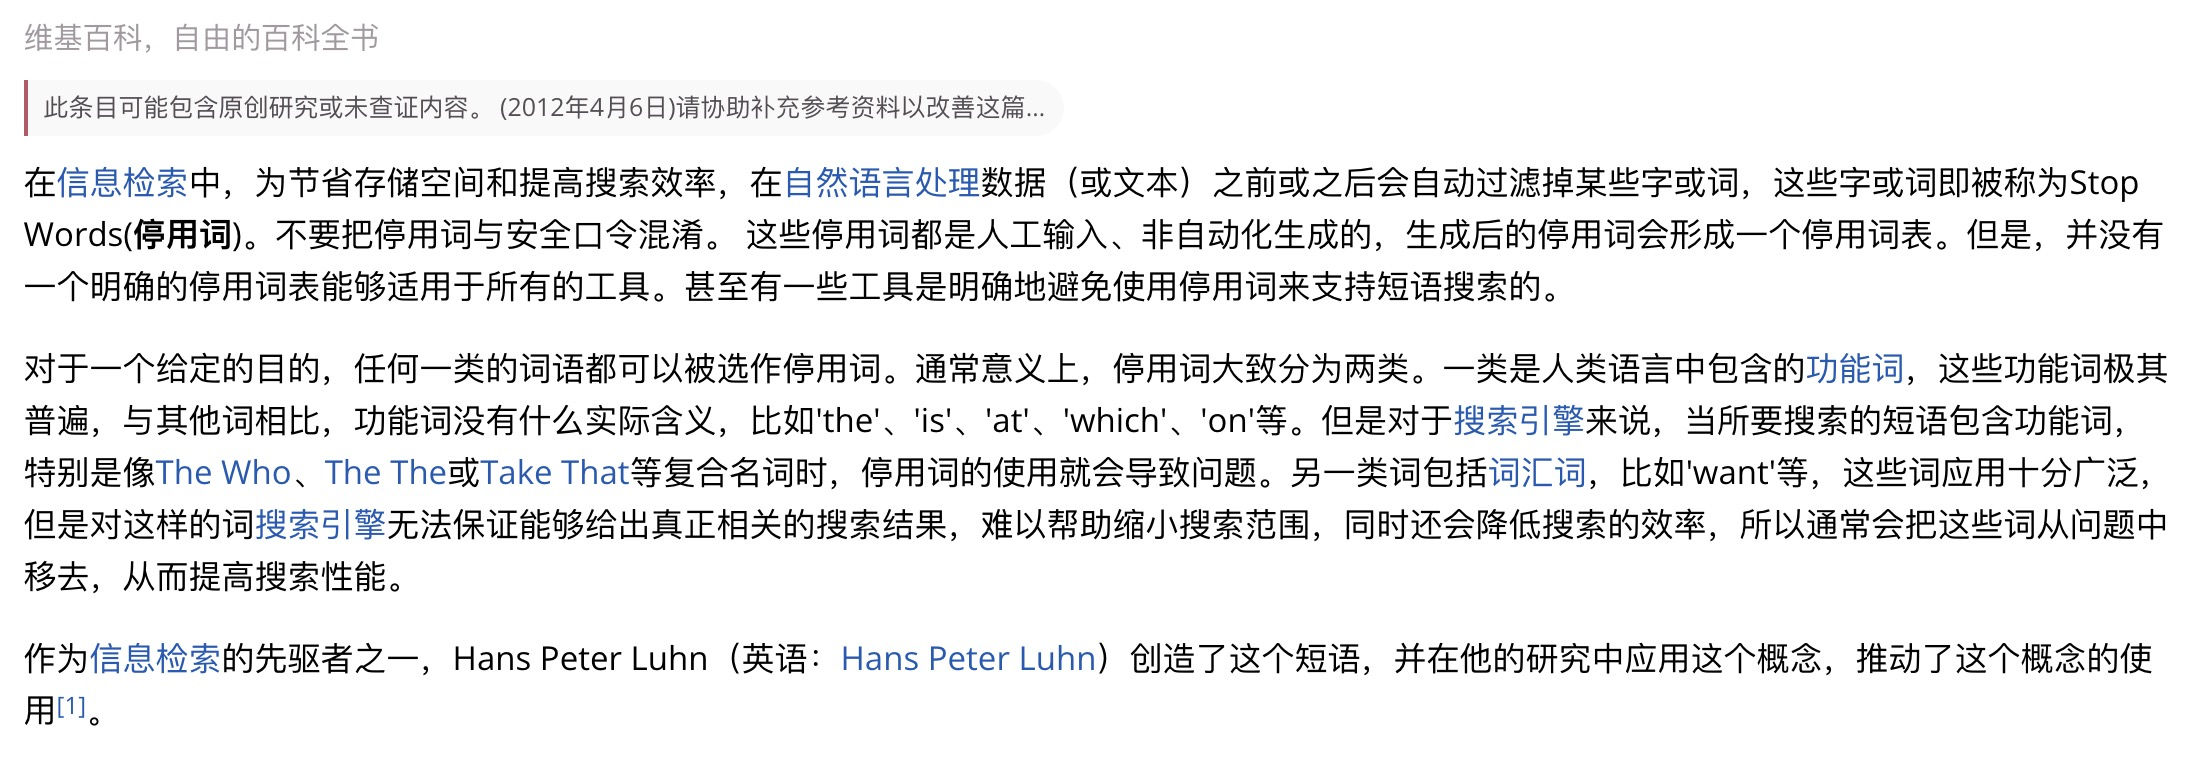

In [129]:
def score_intersection(doc1, doc2):
    stop_word_set = set([' ', '$', '-', '.', '/', '！', '，', '：', '？', '是', '让', '了', '的', '啊', '吧'])
    
    word_set_doc1 = set(jieba.cut(doc1.lower()))
    word_set_doc2 = set(jieba.cut(doc2.lower()))
    return len(word_set_doc1 & word_set_doc2 - stop_word_set)

In [130]:
print(f"score of doc_1: {score_intersection(q, doc_1)}\nscore of doc_2: {score_intersection(q, doc_2)}")

score of doc_1: 2
score of doc_2: 2


#### Jaccard系数(Jaccard index)  -> Jaccard距离
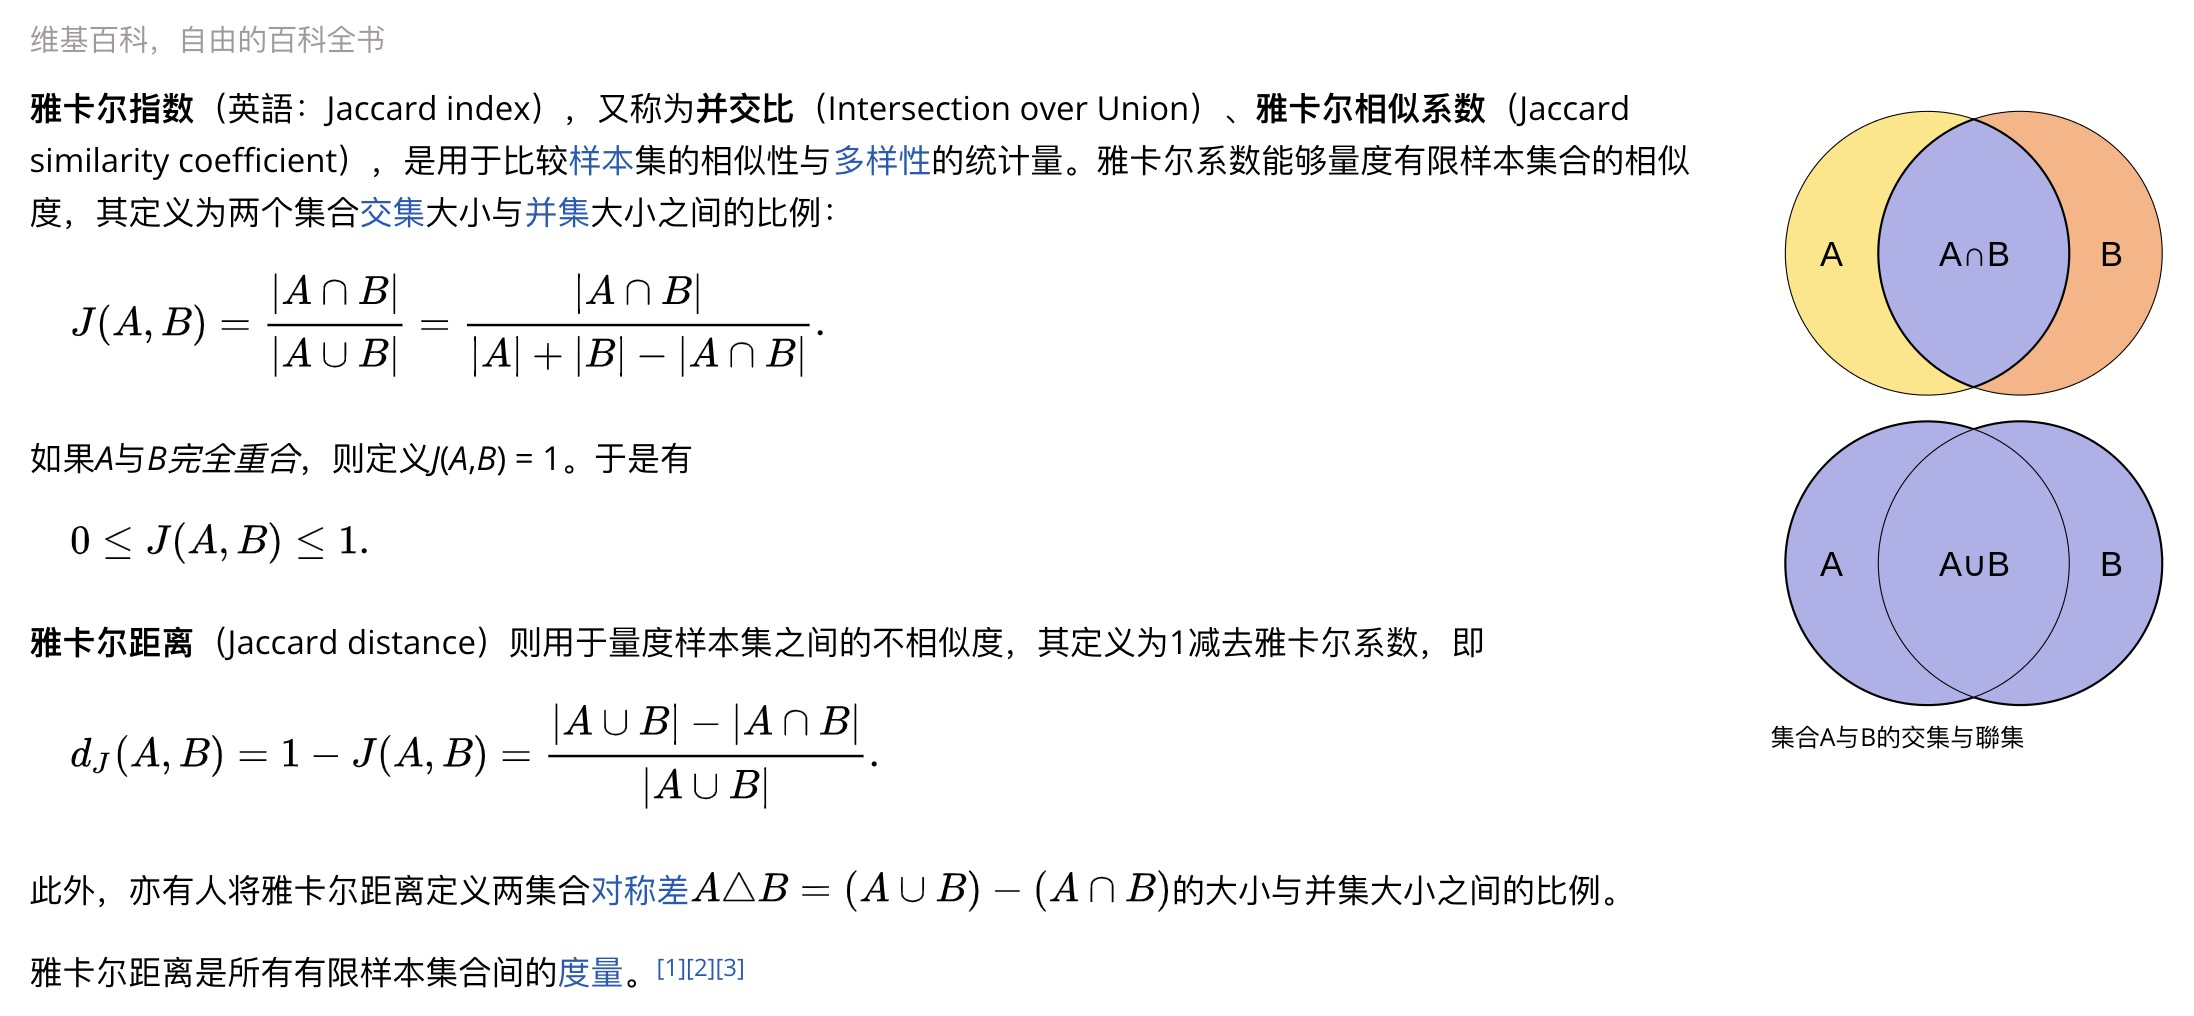

### * 相似度(Similarity) vs. 距离(Distance)

#### Jaccard相似度
#### 考虑了文档长度对相似度的影响，文档越长，相似度越低
\begin{equation}
\operatorname{score}(Q, D)=\frac{|Q \cap D|}{|Q|+|D|-|Q \cap D|}
\end{equation}

In [131]:
def score_jaccard(doc1, doc2):
    word_set_doc1 = set(jieba.cut(doc1.lower()))
    word_set_doc2 = set(jieba.cut(doc2.lower()))
    return len(word_set_doc1 & word_set_doc2) \
                        / (len(word_set_doc1) + len(word_set_doc2) - len(word_set_doc1 & word_set_doc2))

In [132]:
print(f"score of doc_1: {score_jaccard(q, doc_1)}\nscore of doc_2: {score_jaccard(q, doc_2)}")

score of doc_1: 0.007936507936507936
score of doc_2: 0.022900763358778626


### 改进方向……

## 向量空间模型

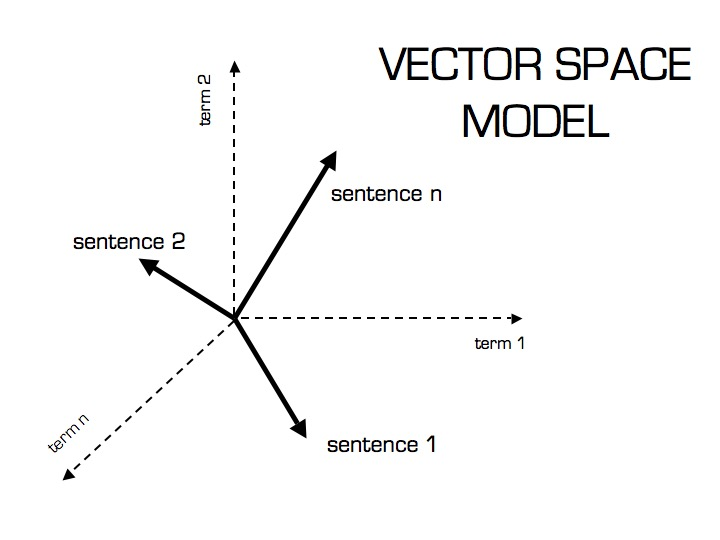

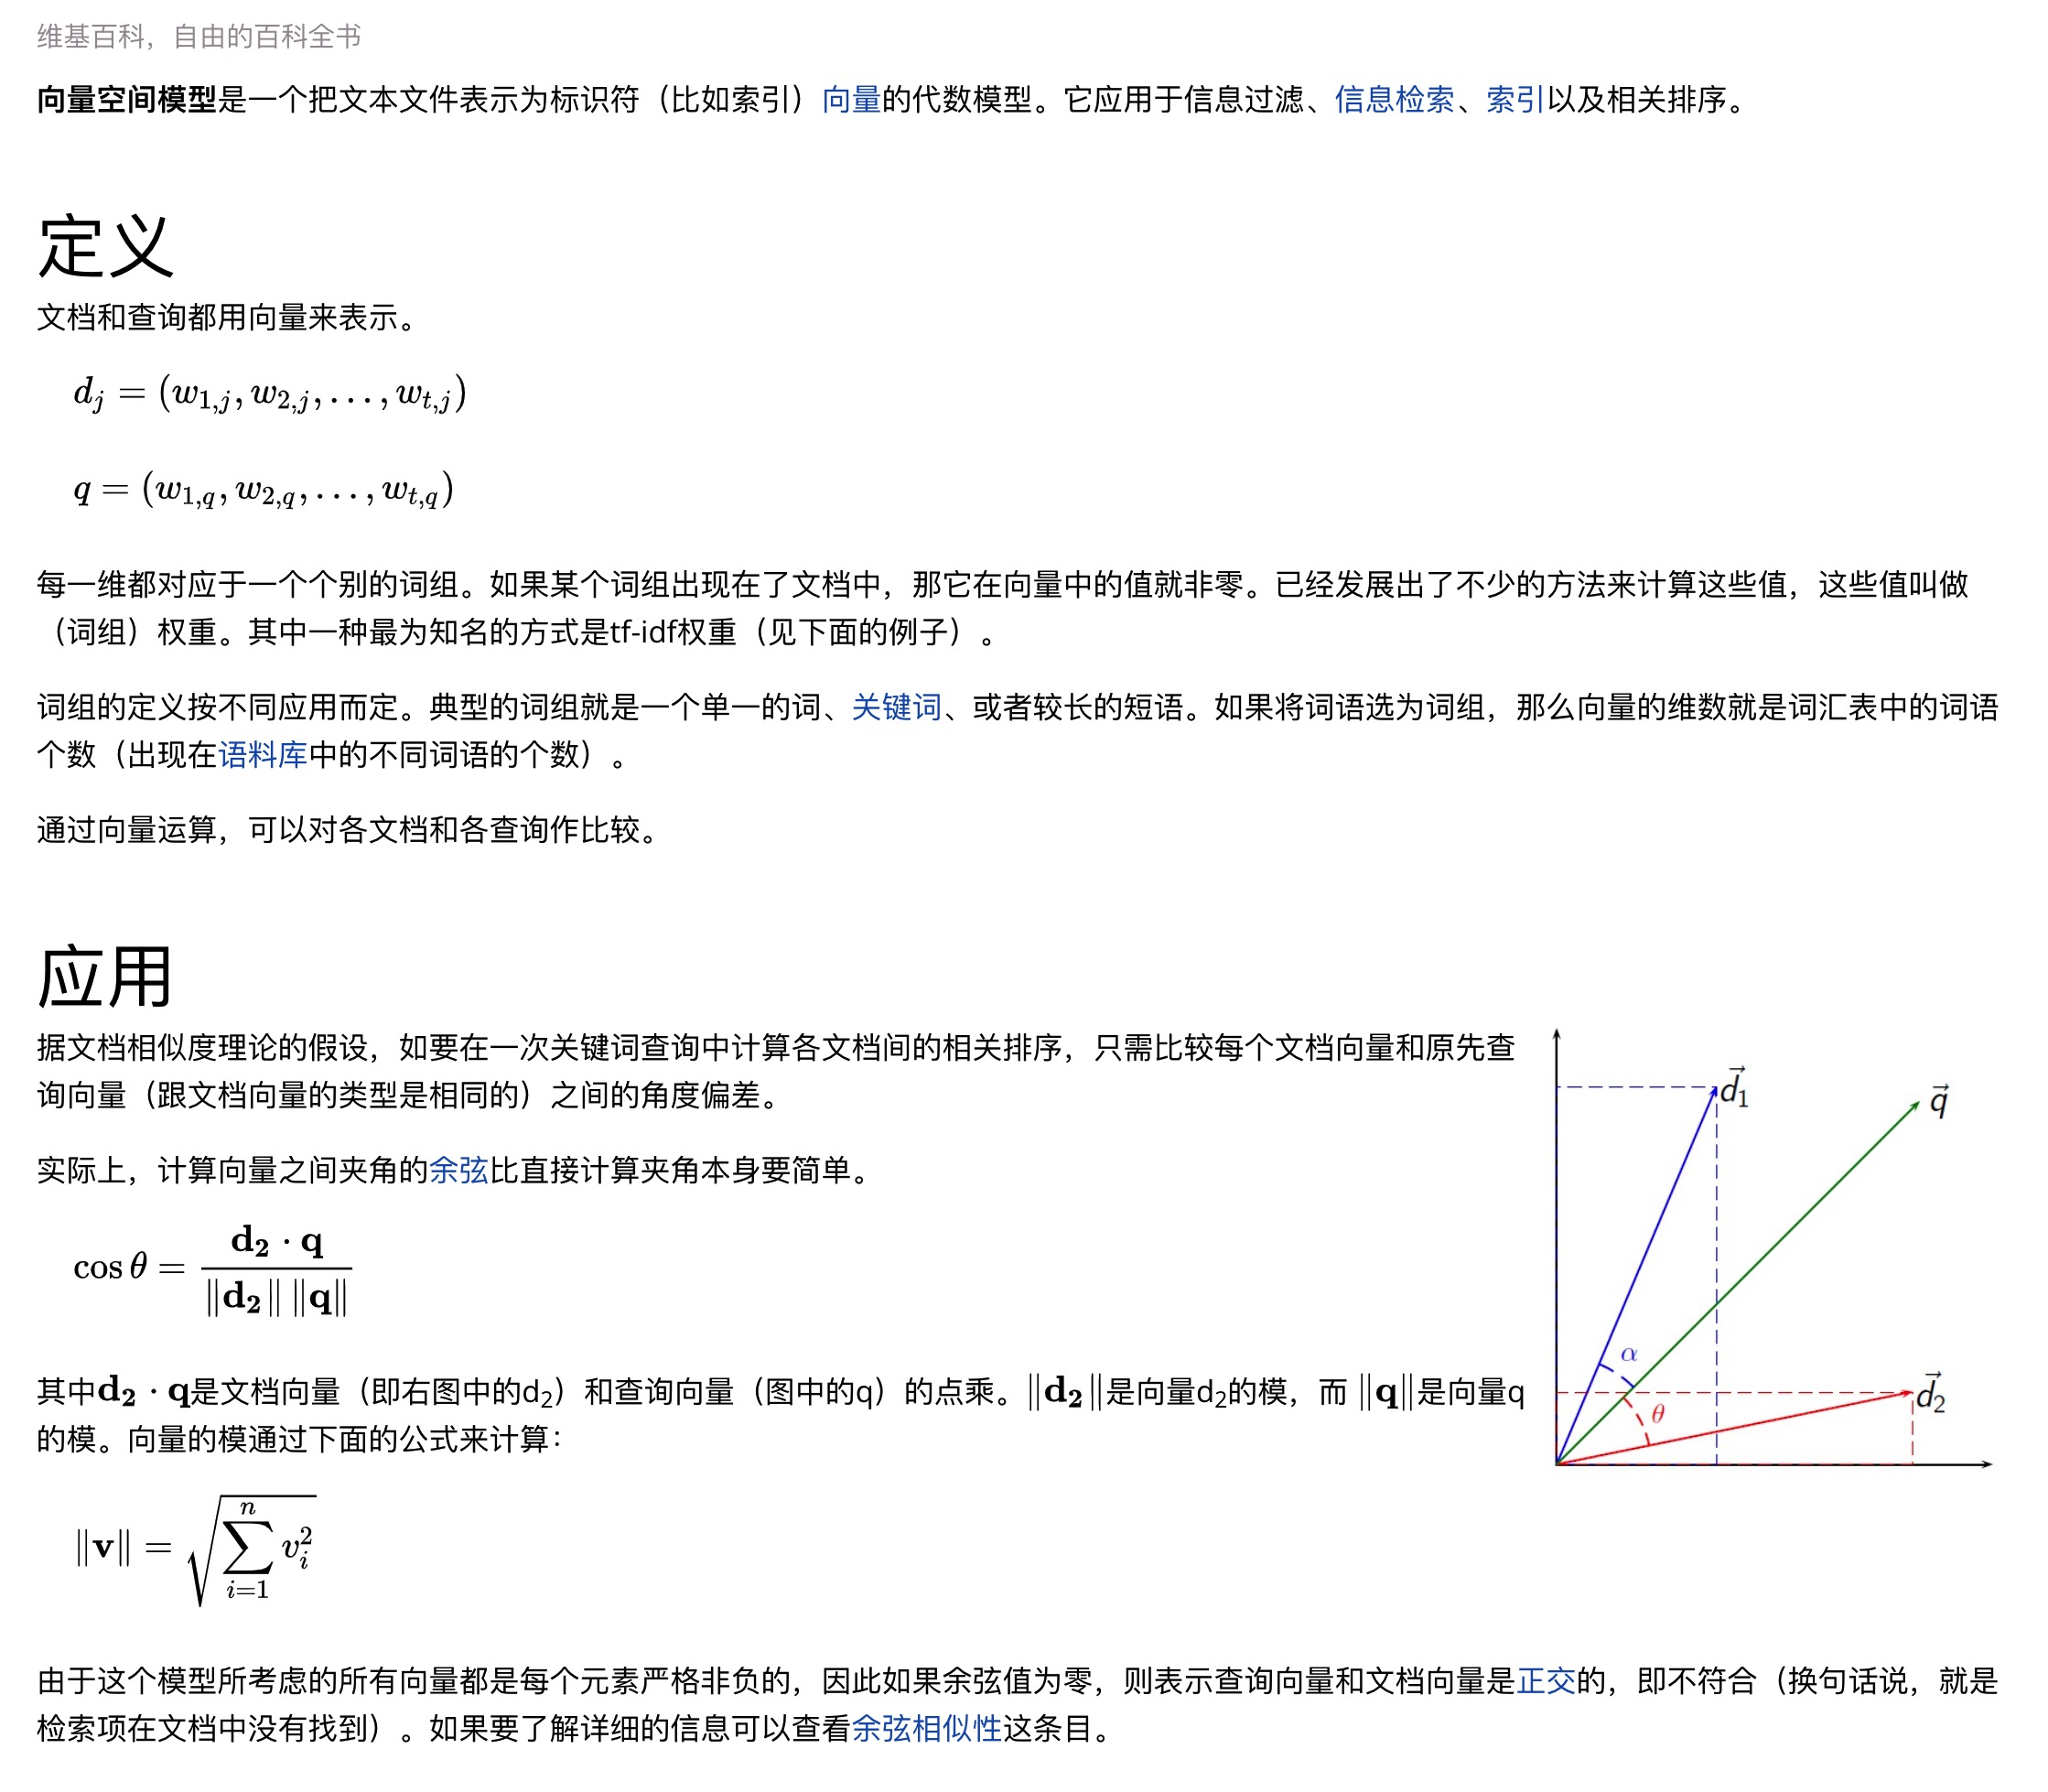

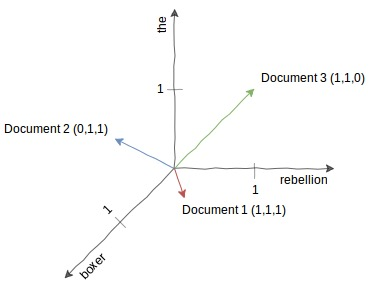

In [133]:
from math import sqrt

def score_vsm(doc1, doc2):
    stop_word_set = set([' ', '$', '-', '.', '/', '！', '，', '：', '？', '“', '”', '、', '。', ':', ';', '@', '是', '让', '了', '的', '啊', '吧'])
    
    word_set_doc1 = set(jieba.cut(doc1.lower()))
    word_set_doc2 = set(jieba.cut(doc2.lower()))
    
    #获取词典(词表，所有词的集合)
    vocabulary = sorted(list((word_set_doc1 | word_set_doc2) - stop_word_set))
    
    #生成one-hot表示的文档向量，每一维用0/1表示该词是否出现
    vector_doc1 = [1 if word in word_set_doc1 else 0 for word in vocabulary]
    vector_doc2 = [1 if word in word_set_doc2 else 0 for word in vocabulary]
    
    #夹角余弦相似度的计算 cosine  = ( V1 * V2 ) / ||V1|| x ||V2||
    cosine = sum([vector_doc1[i] * vector_doc2[i] for i in range(len(vocabulary))]) \
        /(sqrt(sum([vector_doc1[i] * vector_doc1[i] for i in range(len(vocabulary))])) \
        * sqrt(sum([vector_doc2[i] * vector_doc2[i] for i in range(len(vocabulary))])))
    
    return cosine

In [134]:
print(f"score of doc_1: {score_vsm(q, doc_1)}\nscore of doc_2: {score_vsm(q, doc_2)}")

score of doc_1: 0.07474350927519358
score of doc_2: 0.13074409009212268


### 面向文档比较的改进：统一向量空间(维度)

In [136]:
from math import sqrt

def score_vsm(doc1, doc2, vocabulary):
    word_set_doc1 = set(jieba.cut(doc1.lower()))
    word_set_doc2 = set(jieba.cut(doc2.lower()))
    
    #生成one-hot表示的文档向量，每一维用0/1表示该词是否出现
    vector_doc1 = [1 if word in word_set_doc1 else 0 for word in vocabulary]
    vector_doc2 = [1 if word in word_set_doc2 else 0 for word in vocabulary]
    
    #夹角余弦相似度的计算 cosine  = ( V1 * V2 ) / ||V1|| x ||V2||
    cosine = sum([vector_doc1[i] * vector_doc2[i] for i in range(len(vocabulary))]) \
        /(sqrt(sum([vector_doc1[i] * vector_doc1[i] for i in range(len(vocabulary))])) \
        * sqrt(sum([vector_doc2[i] * vector_doc2[i] for i in range(len(vocabulary))])))
    
    return cosine

In [137]:
stop_word_set = set([' ', '$', '-', '.', '/', '！', '，', '：', '？', '“', '”', '、', '。', ':', ';', '@', '是', '让', '了', '的', '啊', '吧'])
word_set_q = set(jieba.cut(q.lower()))
word_set_doc_1 = set(jieba.cut(doc_1.lower()))
word_set_doc_2 = set(jieba.cut(doc_2.lower()))
vocabulary = sorted(list((word_set_q | word_set_doc_1 | word_set_doc_2) - stop_word_set))
print(f"score of doc_1: {score_vsm(q, doc_1, vocabulary)}\nscore of doc_2: {score_vsm(q, doc_2, vocabulary)}")

score of doc_1: 0.07474350927519358
score of doc_2: 0.13074409009212268


### 加入词频信息

In [138]:
from math import sqrt

def score_vsm(doc1, doc2, vocabulary):
    word_list_doc1 = list(jieba.cut(doc1.lower()))
    word_list_doc2 = list(jieba.cut(doc2.lower()))
    
    #生成词计数表示的文档向量，每一维用0/1表示该词是否出现
    vector_doc1 = [word_list_doc1.count(word) for word in vocabulary]
    vector_doc2 = [word_list_doc2.count(word) for word in vocabulary]
    
    #夹角余弦相似度的计算 cosine  = ( V1 * V2 ) / ||V1|| x ||V2||
    cosine = sum([vector_doc1[i] * vector_doc2[i] for i in range(len(vocabulary))]) \
        /(sqrt(sum([vector_doc1[i] * vector_doc1[i] for i in range(len(vocabulary))])) \
        * sqrt(sum([vector_doc2[i] * vector_doc2[i] for i in range(len(vocabulary))])))
    
    return cosine

In [139]:
stop_word_set = set([' ', '$', '-', '.', '/', '！', '，', '：', '？', '“', '”', '、', '。', ':', ';', '@', '是', '让', '了', '的', '啊', '吧'])
word_set_q = set(jieba.cut(q.lower()))
word_set_doc_1 = set(jieba.cut(doc_1.lower()))
word_set_doc_2 = set(jieba.cut(doc_2.lower()))
vocabulary = sorted(list((word_set_q | word_set_doc_1 | word_set_doc_2) - stop_word_set))
print(f"score of doc_1: {score_vsm(q, doc_1, vocabulary)}\nscore of doc_2: {score_vsm(q, doc_2, vocabulary)}")

score of doc_1: 0.3922077957854423
score of doc_2: 0.20739033894608505


### 关于相似度得分的思考

### 向量空间维度是否正交？重要性是否均等？

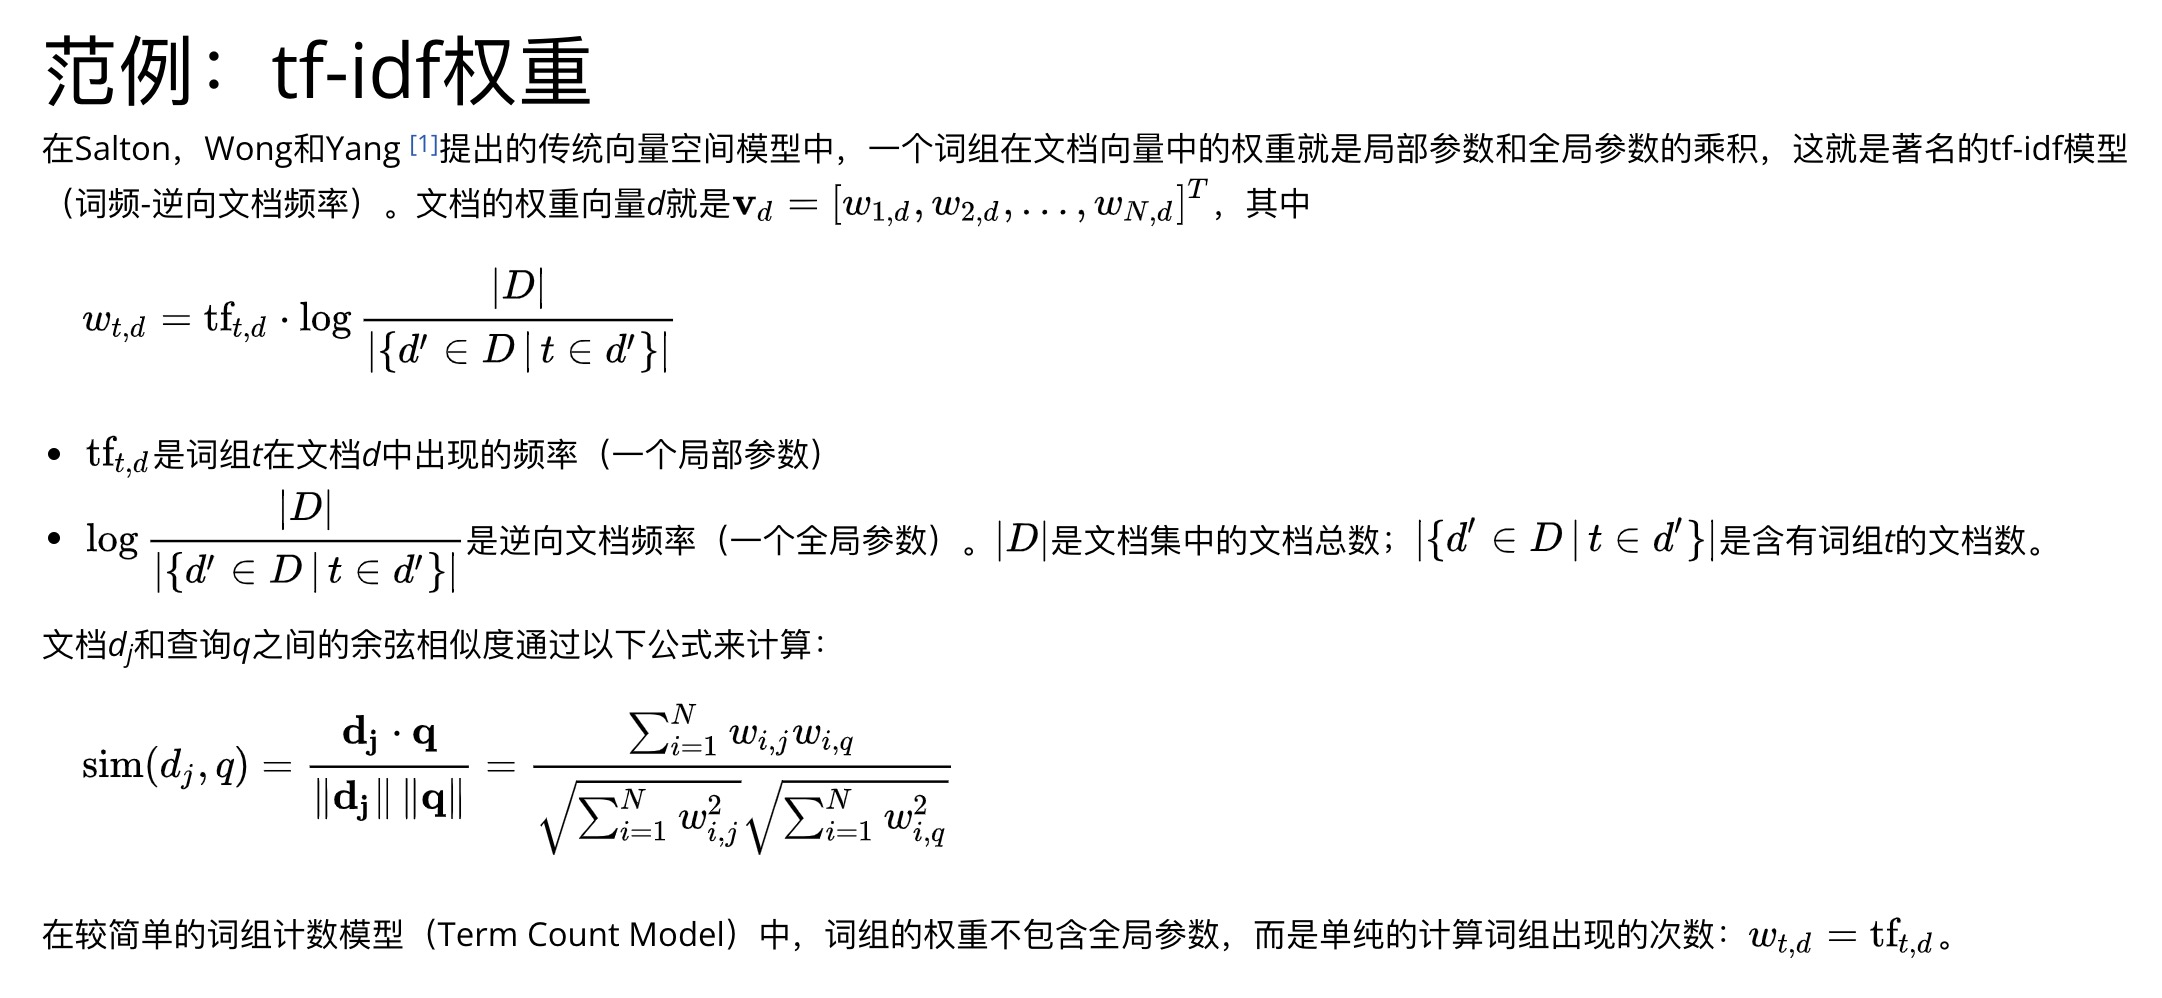

In [ ]:
from math import sqrt
    
class VSMOneHot():
    def __init__(self, doc_list):
        self.stop_word_set = set([' ', '$', '-', '.', '/', '！', '，', '：', '？', '“', '”', '、', '。', ':', ';', '@', '是', '让', '了', '的', '啊', '吧'])
        self.vocabulary = []
        for doc in doc_list:
            self.vocabulary += list(jieba.cut(doc.lower()))
        self.vocabulary = sorted(list(set(self.vocabulary) - self.stop_word_set))
    
    def score(self, q, doc):
        vector_q = self.vectorize(q)
        vector_doc = self.vectorize(doc)
        return self.cosine(vector_q, vector_doc)

    def vectorize(self, doc):
        word_set = set(jieba.cut(doc.lower()))
        return [1 if word in word_set else 0 for word in self.vocabulary]
                          
    def cosine(self, vec1, vec2):
        return sum([vec1[i] * vec2[i] for i in range(len(self.vocabulary))]) \
            /(sqrt(sum([vec1[i] * vec1[i] for i in range(len(self.vocabulary))])) \
            * sqrt(sum([vec2[i] * vec2[i] for i in range(len(self.vocabulary))])))

In [ ]:
vsm_model = VSMOneHot([doc_1, doc_2])

In [ ]:
print(f"score of doc_1: {vsm_model.score(q, doc_1)}\nscore of doc_2: {vsm_model.score(q, doc_2)}")

### 加入：
#### TF: 词频（前景）
#### DF: 文档频（背景）

In [ ]:
from math import sqrt, log10
from collections import defaultdict    
    
class VSMTFIDF():
    def __init__(self, doc_list):
        self.stop_word_set = set([' ', '$', '-', '.', '/', '！', '，', '：', '？', '“', '”', '、', '。', ':', ';', '@', '是', '让', '了', '的', '啊', '吧'])
        self.doc_count = len(doc_list)
        self.vocabulary = []
        self.df = defaultdict(int)
        for doc in doc_list:
            doc_word_set = set(jieba.cut(doc.lower()))
            for word in doc_word_set:
                self.df[word] += 1
            self.vocabulary += list(doc_word_set)
        self.vocabulary = sorted(list(set(self.vocabulary) - self.stop_word_set))
    
    def score(self, q, doc):
        vector_q = self.vectorize(q)
        vector_doc = self.vectorize(doc)
        result = self.cosine(vector_q, vector_doc)
        return result

    def vectorize(self, doc):
        result = []
        word_list = list(jieba.cut(doc.lower()))
        word_set = set(word_list)
        for word in self.vocabulary:
            tf = word_list.count(word)
            idf = sqrt(self.doc_count / self.df[word])
            result.append(tf * idf)        
        return result
                          
    def cosine(self, vec1, vec2):
        return sum([vec1[i] * vec2[i] for i in range(len(self.vocabulary))]) \
            /(sqrt(sum([vec1[i] * vec1[i] for i in range(len(self.vocabulary))])) \
            * sqrt(sum([vec2[i] * vec2[i] for i in range(len(self.vocabulary))])))

In [ ]:
vsm_model = VSMTFIDF([doc_1, doc_2])

In [ ]:
print(f"score of doc_1: {vsm_model.score(q, doc_1)}\nscore of doc_2: {vsm_model.score(q, doc_2)}")

### TF：词频 —— **词的`匹配性`**
### DF：文档频 —— **词的`区分性`**
### 思考：DF应该在什么范围内进行统计？

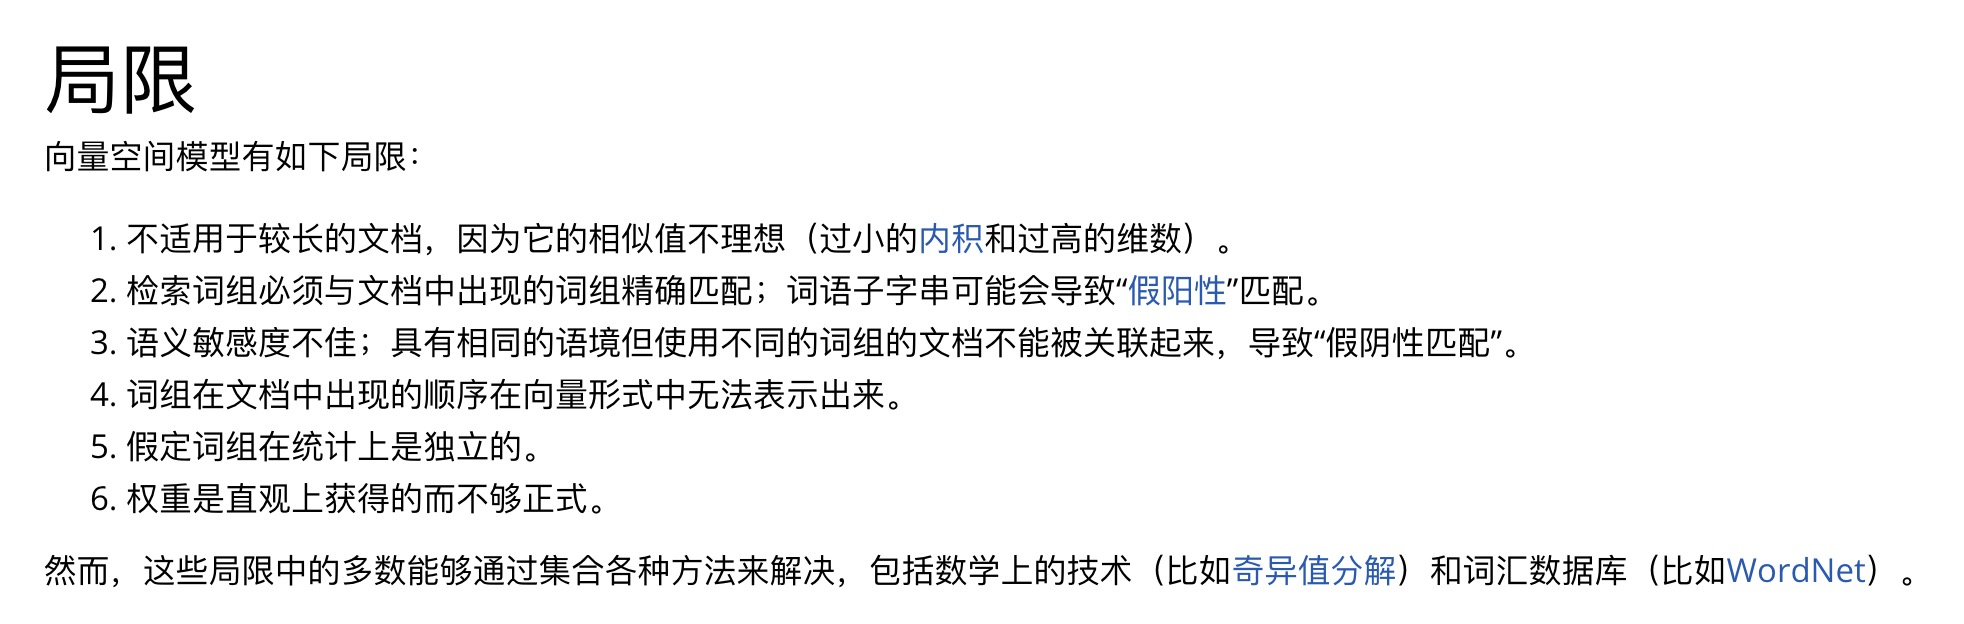

In [ ]:
from IPython.core.display import display, HTML
import bisect
from collections import defaultdict
import jieba
import pickle
from math import sqrt, log10
from collections import defaultdict    
    
class VSMTFIDF():
    def __init__(self, doc_list):
        self.stop_word_set = set([' ', '$', '-', '.', '/', '！', '，', '：', '？', '“', '”', '、', '。', ':', ';', '@', '是', '让', '了', '的', '啊', '吧'])
        self.doc_count = len(doc_list)
        self.vocabulary = []
        self.df = defaultdict(int)
        for doc in doc_list:
            doc_word_set = set(jieba.cut(doc.lower()))
            for word in doc_word_set:
                self.df[word] += 1
            self.vocabulary += list(doc_word_set)
        self.vocabulary = sorted(list(set(self.vocabulary) - self.stop_word_set))
    
    def score(self, q, doc):
        vector_q = self.vectorize(q)
        vector_doc = self.vectorize(doc)
        result = self.cosine(vector_q, vector_doc)
        return result

    def vectorize(self, doc):
        result = []
        word_list = list(jieba.cut(doc.lower()))
        word_set = set(word_list)
        for word in self.vocabulary:
            tf = word_list.count(word)
            idf = sqrt(self.doc_count / self.df[word])
            result.append(tf * idf)        
        return result
                          
    def cosine(self, vec1, vec2):
        return sum([vec1[i] * vec2[i] for i in range(len(self.vocabulary))]) \
            /(sqrt(sum([vec1[i] * vec1[i] for i in range(len(self.vocabulary))])) \
            * sqrt(sum([vec2[i] * vec2[i] for i in range(len(self.vocabulary))])))

class MySearchC5V1(MySearchC5V0):
    """
    C3V0: Base class for Search Engine.
    C3V1: Data multiplication added.
    C3V2: Sorting optimization.
    C3V3: Add lowered version of docs.
    C3V4: For long doc.
    C3V5: Caching search results.
    C3V6: Pre-caching all words in docs.
    C3V7: Add Serialize/UnSerialize.
    C4V1: Add basic Bool query support
    C4V2: Add wordseg to get_word_match()
    ----------------C5V0-----------------
    C5V1: Use VSMTFIDF.score() as score

    Attributes
    ----------
    filename : str
        file name of doc data
    multi_factor : int
        data multiplication factor(default 1)

    Methods
    -------
    load_data(filename):
        load data from file.
    save_data(filename):
        save data to file
    pre_cache_all():
        Pre-caching all words in docs.
    highlight(text, keyword):
        highlight text with keyword.
    score(text, keyword):
        get score of text for a query.
    get_word_match(self, keyword):
        get doc set containing keyword.
    search(keyword, num=15):
        get top num search results of a query.
    render(result_list, keyword):
        output search results with highlight.
    query_to_set_expression(query):
        convert bool query to set expression(for eval process).
    get_word_match(word):
        get match set of the word.
    """
    
    def search(self, query, num=15):
        query_lower = query.lower()    
        result_list = []
        min_score = 0
        query_new = self.query_to_set_expression(query_lower)
        match_tid_list = list(eval(query_new))
        vsm_model = VSMTFIDF([self.docs_lower[tid] for tid in match_tid_list])
        query_new = ' '.join(set(jieba.cut(query_lower)) - set(['(', ')', 'and', 'AND', '+', 'or', 'OR', 'NOT', 'not', '+', '-', ' ', '']))
        result_list = [(tid, vsm_model.score(query_new, self.docs_lower[tid])) for tid in match_tid_list]
        result_list.sort(key = lambda x: x[1], reverse=True)
        return [doc_id for doc_id, _ in result_list[:num]]

In [ ]:
searcher = MySearchC5V1('titles_l.dat', 1)

In [ ]:
query = '手机 AND 性能'
search_result = searcher.search(query, num=10)
searcher.render(search_result, query)

### BM25(Okapi BM25)  
#### BM25是信息索引领域用来计算query与文档相似度得分的经典算法。  

\begin{equation}
\operatorname{score}(D, Q)=\sum_{i=1}^{n} \operatorname{IDF}\left(q_{i}\right) \cdot \frac{f\left(q_{i}, D\right) \cdot\left(k_{1}+1\right)}{f\left(q_{i}, D\right)+k_{1} \cdot\left(1-b+b \cdot \frac{|D|}{\text { avgdl }}\right)}
\end{equation}  
\begin{equation}
\operatorname{IDF}\left(q_{i}\right)=\ln \left(\frac{N-n\left(q_{i}\right)+0.5}{n\left(q_{i}\right)+0.5}+1\right)
\end{equation}

In [ ]:
from math import log
from collections import defaultdict

class BM25():
    def __init__(self, doc_list):
        self.doc_count = len(doc_list)
        self.avgdl = 0
        self.df = defaultdict(int)
        for doc in doc_list:
            for word in set(jieba.cut(doc)):
                self.df[word] += 1
            self.avgdl += len(doc)
        self.avgdl /= self.doc_count
    
    def score(self, q, doc):
        k1 = 1.5
        b = 0.75
        result = 0
        query_new = set(jieba.cut(q.lower())) - set(['(', ')', 'and', 'AND', '+', 'or', 'OR', 'NOT', 'not', '+', '-', ' ', ''])
        word_list_doc = list(jieba.cut(doc.lower()))
        for keyword in query_new:
            f = word_list_doc.count(keyword)
            dl = len(doc)
            idf = log((self.doc_count - self.df[keyword] + 0.5) / (self.df[keyword] + 0.5) + 1)
            result += idf * ((f * (k1 + 1)) / (f + k1 * (1 - b + b * dl / self.avgdl)))
        return result

In [ ]:
bm25_model = BM25([doc_1, doc_2])

In [ ]:
print(f"score of doc_1: {bm25_model.score(q, doc_1)}\nscore of doc_2: {bm25_model.score(q, doc_2)}")

In [ ]:
from IPython.core.display import display, HTML
import bisect
from collections import defaultdict
import jieba
import pickle
from math import sqrt, log
from collections import defaultdict    
    
class BM25():
    def __init__(self, doc_list):
        self.doc_count = len(doc_list)
        self.avgdl = 0
        self.df = defaultdict(int)
        for doc in doc_list:
            for word in set(jieba.cut(doc)):
                self.df[word] += 1
            self.avgdl += len(doc)
        self.avgdl /= self.doc_count
    
    def score(self, q, doc):
        k1 = 1.5
        b = 0.75
        result = 0
        query_new = set(jieba.cut(q.lower())) - set(['(', ')', 'and', 'AND', '+', 'or', 'OR', 'NOT', 'not', '+', '-', ' ', ''])
        word_list_doc = list(jieba.cut(doc.lower()))
        for keyword in query_new:
            f = word_list_doc.count(keyword)
            dl = len(doc)
            idf = log((self.doc_count - self.df[keyword] + 0.5) / (self.df[keyword] + 0.5) + 1)
            result += idf * ((f * (k1 + 1)) / (f + k1 * (1 - b + b * dl / self.avgdl)))
        return result
    

class MySearchC5V2(MySearchC5V0):
    """
    C3V0: Base class for Search Engine.
    C3V1: Data multiplication added.
    C3V2: Sorting optimization.
    C3V3: Add lowered version of docs.
    C3V4: For long doc.
    C3V5: Caching search results.
    C3V6: Pre-caching all words in docs.
    C3V7: Add Serialize/UnSerialize.
    C4V1: Add basic Bool query support
    C4V2: Add wordseg to get_word_match()
    ----------------C5V0-----------------
    C5V1: Use VSMTFIDF.score() as score
    C5V2: Use BM25.score() as score

    Attributes
    ----------
    filename : str
        file name of doc data
    multi_factor : int
        data multiplication factor(default 1)

    Methods
    -------
    load_data(filename):
        load data from file.
    save_data(filename):
        save data to file
    pre_cache_all():
        Pre-caching all words in docs.
    highlight(text, keyword):
        highlight text with keyword.
    score(text, keyword):
        get score of text for a query.
    get_word_match(self, keyword):
        get doc set containing keyword.
    search(keyword, num=15):
        get top num search results of a query.
    render(result_list, keyword):
        output search results with highlight.
    query_to_set_expression(query):
        convert bool query to set expression(for eval process).
    get_word_match(word):
        get match set of the word.
    """
    
    def search(self, query, num=15):
        query_lower = query.lower()    
        result_list = []
        min_score = 0
        query_new = self.query_to_set_expression(query_lower)
        match_tid_list = list(eval(query_new))
        bm25_model = BM25([self.docs_lower[tid] for tid in match_tid_list])
        query_new = ' '.join(set(jieba.cut(query_lower)) - set(['(', ')', 'and', 'AND', '+', 'or', 'OR', 'NOT', 'not', '+', '-', ' ', '']))
        result_list = [(tid, bm25_model.score(query_new, self.docs_lower[tid])) for tid in match_tid_list]
        result_list.sort(key = lambda x: x[1], reverse=True)
        return [doc_id for doc_id, _ in result_list[:num]]

In [ ]:
searcher = MySearchC5V2('titles_l.dat', 1)

In [ ]:
query = '手机 AND 性能'
search_result = searcher.search(query, num=10)
searcher.render(search_result, query)